### Calculate the luminosity during each segment

$L_{\gamma} = 4\pi D_L ^2 \int_{E_{min}}^{E_{max}} E \dfrac{dN}{dE} dE$

$D_L = 134.1$ $Mpc$

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table
from astropy import units as u
from scipy import interpolate

In [2]:
dir = '3B-20180206-20180622/'

lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
emin = 0.1 *u.GeV
emax = 300 *u.GeV
D_l = 134.1 *u.Mpc
hdul = fits.open('./' + dir+lc_file_path)

In [3]:
lc = hdul[1].data

In [4]:
Table(lc).colnames

['tmin',
 'tmax',
 'tmin_mjd',
 'tmax_mjd',
 'loglike_const',
 'flux_const',
 'fit_success',
 'fit_success_fixed',
 'fit_status',
 'fit_quality',
 'num_free_params',
 'param_names',
 'param_names_fixed',
 'param_values',
 'param_values_fixed',
 'param_errors',
 'param_errors_fixed',
 'ts',
 'ts_fixed',
 'loglike',
 'loglike_fixed',
 'loglike_scan',
 'loglike_scan_fixed',
 'dloglike_scan',
 'dloglike_scan_fixed',
 'eflux_scan',
 'eflux_scan_fixed',
 'flux_scan',
 'flux_scan_fixed',
 'norm_scan',
 'norm_scan_fixed',
 'npred',
 'npred_fixed',
 'npred_wt',
 'npred_wt_fixed',
 'pivot_energy',
 'pivot_energy_fixed',
 'flux',
 'flux_fixed',
 'flux100',
 'flux100_fixed',
 'flux1000',
 'flux1000_fixed',
 'flux10000',
 'flux10000_fixed',
 'flux_err',
 'flux_err_fixed',
 'flux100_err',
 'flux100_err_fixed',
 'flux1000_err',
 'flux1000_err_fixed',
 'flux10000_err',
 'flux10000_err_fixed',
 'flux_ul95',
 'flux_ul95_fixed',
 'flux100_ul95',
 'flux100_ul95_fixed',
 'flux1000_ul95',
 'flux1000_ul95_fi

#### Plotting spline fit

In [5]:
# flux = lc[1]['flux']
# flux_err = lc[1]['flux_err']

# tmean = (lc['tmin_mjd'] + lc['tmax_mjd'])/2
# TSmin = 9

# if len(lc['eflux'][lc['ts']>TSmin]) > 0:
#     scale = int(np.log10(lc['eflux'][lc['ts']>TSmin].max())) -2
# else:
#     scale = int(np.log10(lc['eflux_ul95'].max())) -2

# f = plt.figure(figsize=(10, 5))
# ax = f.add_subplot(111)
# ax.tick_params(which='major', length=5, direction='in')
# ax.tick_params(which='minor', length=2.5, direction='in',bottom=True, top=True, left=True, right=True)
# ax.tick_params(bottom=True, top=True, left=True, right=True)

# # if len(tmean[lc['ts']>TSmin]) > 9:
# time_continuum = np.linspace(np.min(lc['tmin_mjd']),np.max(lc['tmax_mjd']),10*len(lc['tmin_mjd']))
# tck_flux = interpolate.splrep(tmean[lc['ts']>TSmin], (10**-scale)*lc['flux'][lc['ts']>TSmin], k=3)
# tck_flux_error = interpolate.splrep(tmean[lc['ts']>TSmin], (10**-scale)*lc['flux_err'][lc['ts']>TSmin],k=3)

# flux_continuum = interpolate.splev(time_continuum, tck_flux)
# flux_continuum_err = interpolate.splev(time_continuum, tck_flux_error)
# ax.plot(time_continuum,flux_continuum,color="C1", label="Spline")



# plt.errorbar(tmean[lc['ts']>TSmin], (10**-scale)*lc['flux'][lc['ts']>TSmin], xerr = [ tmean[lc['ts']>TSmin]- lc['tmin_mjd'][lc['ts']>TSmin], lc['tmax_mjd'][lc['ts']>TSmin] - tmean[lc['ts']>TSmin] ], yerr=(10**-scale)*lc['flux_err'][lc['ts']>TSmin], markeredgecolor='black', fmt='o', capsize=4)
# plt.errorbar(tmean[lc['ts']<=TSmin], (10**-scale)*lc['flux_ul95'][lc['ts']<=TSmin], xerr = [ tmean[lc['ts']<=TSmin]- lc['tmin_mjd'][lc['ts']<=TSmin], lc['tmax_mjd'][lc['ts']<=TSmin] - tmean[lc['ts']<=TSmin] ], yerr=5*np.ones(len(lc['flux_err'][lc['ts']<=TSmin])), markeredgecolor='black', fmt='o', uplims=True, color='orange', capsize=4)
# plt.xlabel('Time [MJD]')
# plt.ylabel('Flux * 1e-9 [$erg$ $cm^{-2}$ $s^{-1}$]')

# if len(lc['flux'][lc['ts']>TSmin]) > 0:
#     y0 = (lc['flux'][lc['ts']>TSmin]).max()
#     y1 = (lc['flux'][lc['ts']>TSmin] + lc['flux_err'][lc['ts']>TSmin]).max()
#     if y1 > 4*y0:
#         y1 = 4*y0
    
#     if len(lc['flux_ul95'][lc['ts']<=TSmin]) > 0:
#         y2 = (lc['flux_ul95'][lc['ts']<=TSmin]).max()
#         if y2 > y1:
#             y1 = y2
    
# else:
#     y1 = (lc['flux_ul95'][lc['ts']<=TSmin]).max()



# ymin = -(10**-scale)*0.1*y1               
# plt.ylim(ymin,(10**-scale)*1.1*y1)
# plt.legend()
# plt.title('Light curve')

# ax.grid(linestyle=':',which='both')
# plt.show()

In [6]:
from scipy.integrate import quad

In [7]:
lc['dnde']

array([8.66486898e-13, 5.78694088e-12, 1.83054205e-10, 1.13888523e-14,
       7.39436373e-11, 9.25438104e-12, 6.79252713e-11, 1.78957919e-11],
      dtype='>f8')

In [8]:
emax.to(u.erg).value

0.4806529901999999

In [9]:
def f(e, dnde):
    return dnde * e

dirs = ["1-20150918-20160527",  "2-20160913-20170615",  "3A-20170919-20180123",  "3B-20180206-20180622",  "4-20180918-20190528",  "5-20190928-20200608",  "6-20200915-20210503",  "7-20211101-20220619",  "all-20150918-20220619"]


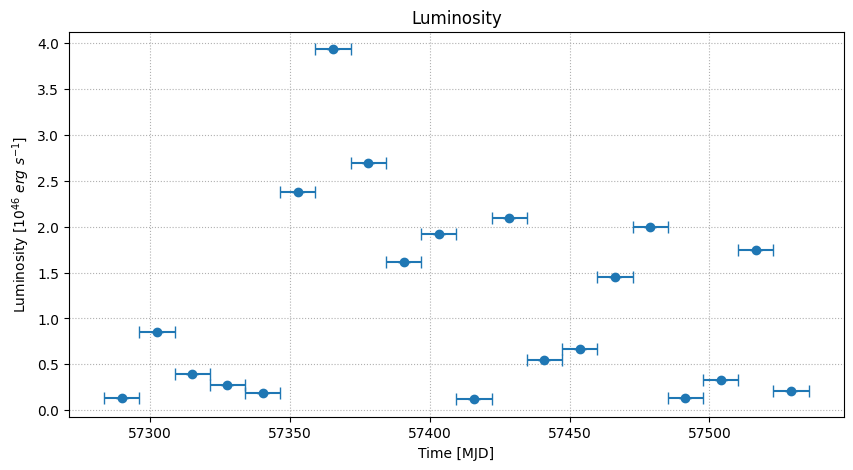

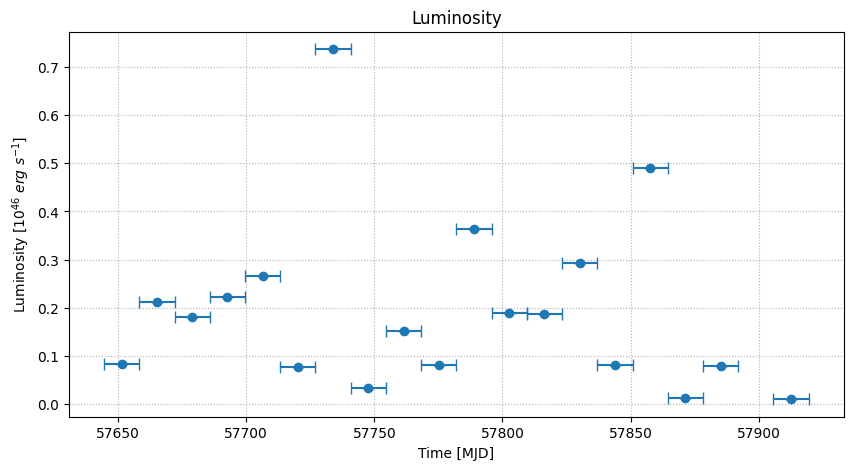

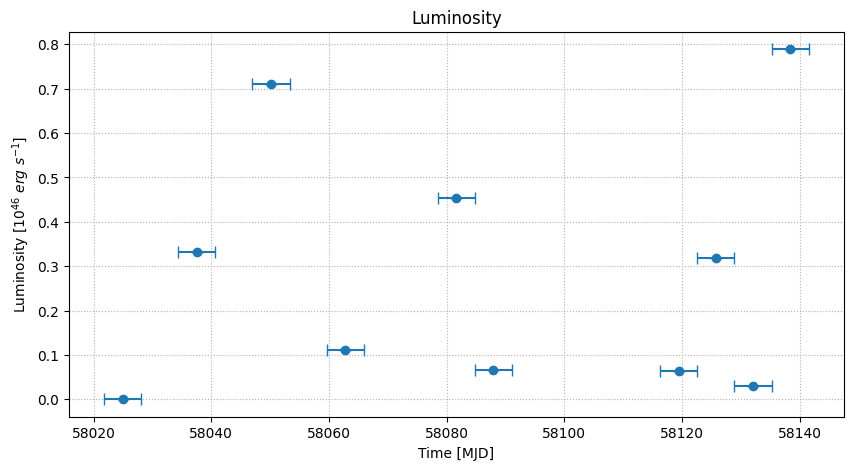

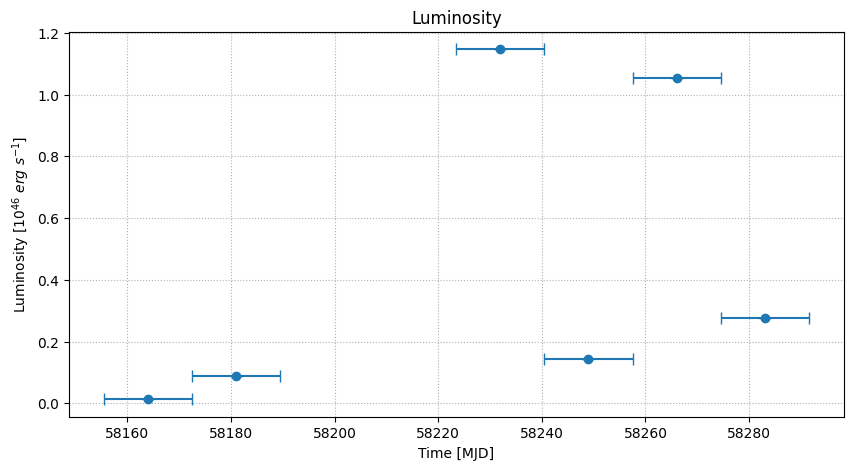

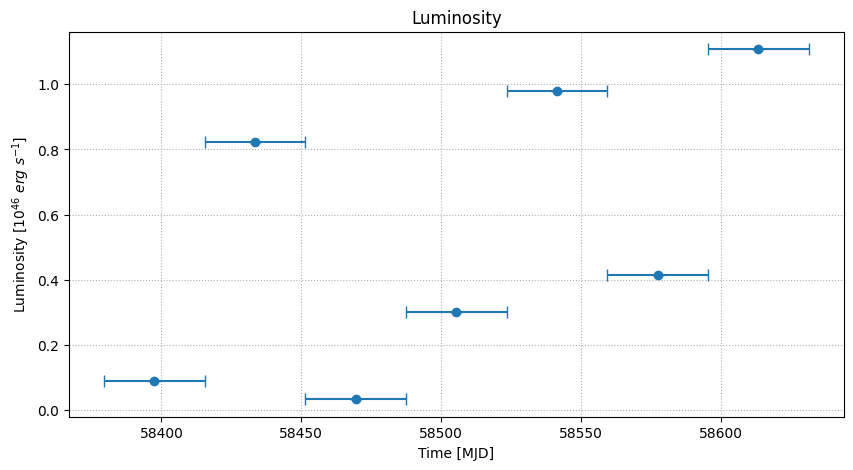

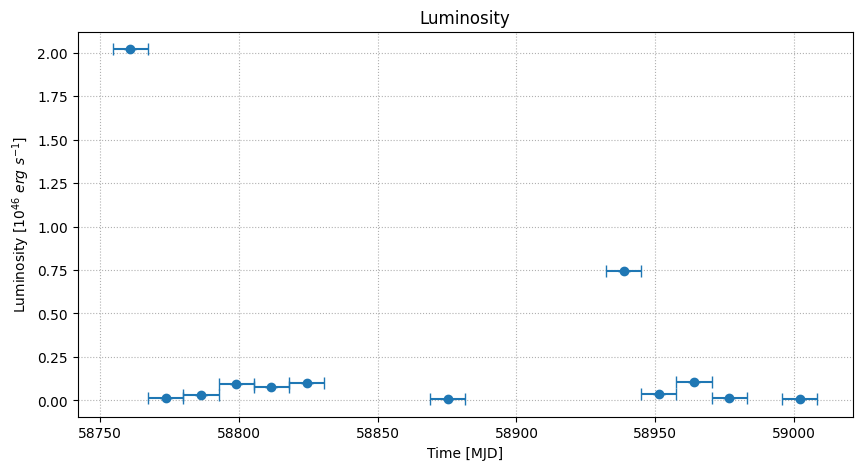

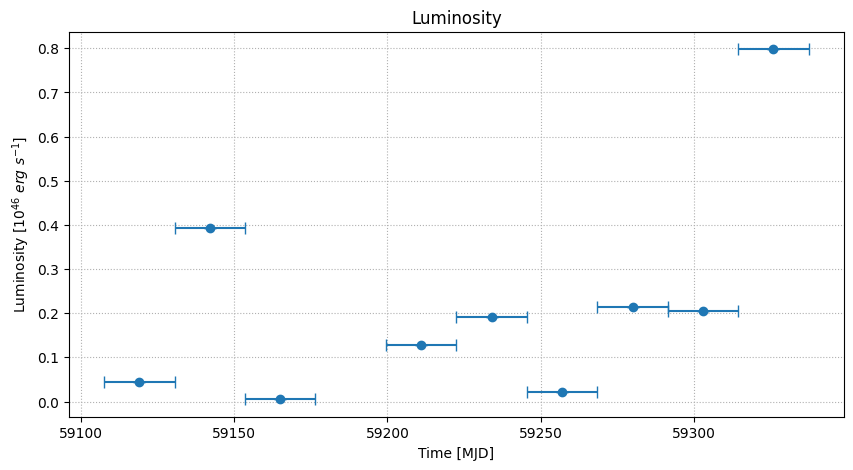

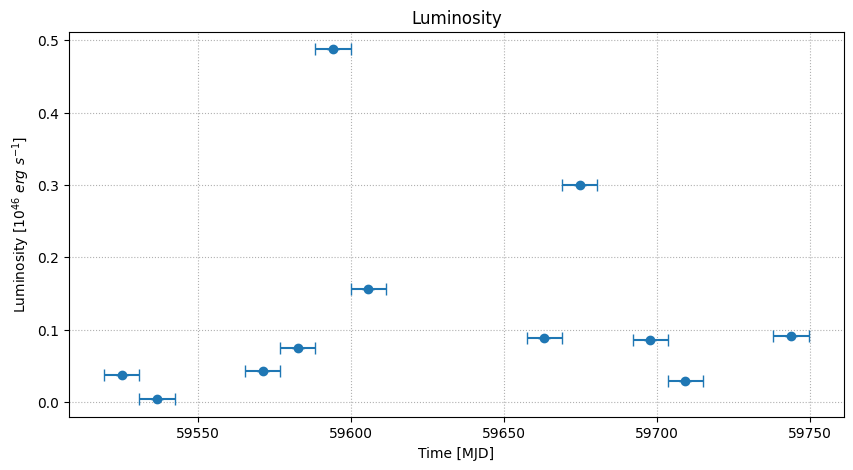

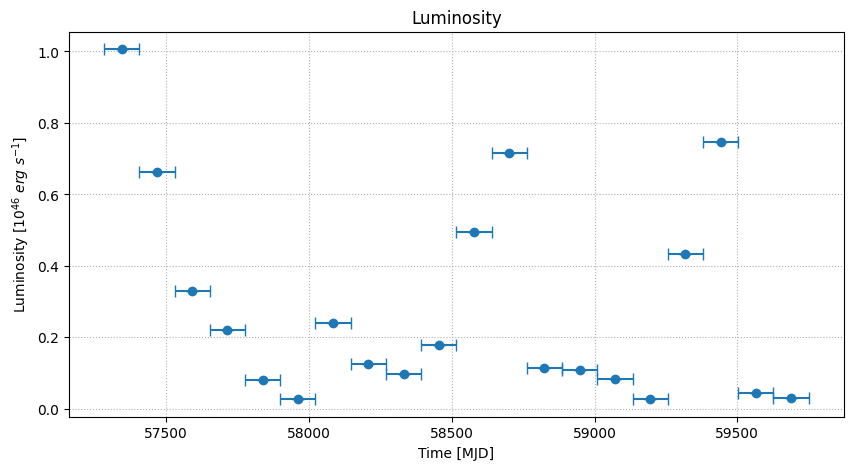

In [10]:
for dir in dirs:
    hdul = fits.open('./' + dir + '/' + lc_file_path)
    lc = hdul[1].data
    luminosity = np.ones(len(lc['tmin_mjd']))
    luminosity_err = np.ones(len(lc['tmin_mjd']))
    for i in range(len(lc['tmin_mjd'])):    
        temp = 4 * np.pi * (D_l.to(u.cm)**2) * quad(f, emin.to(u.erg).value, emax.to(u.erg).value, args=(lc['dnde'][i] * (1/u.GeV).to(1/u.erg).value))
        luminosity[i] = temp[0].value
        luminosity_err[i] = temp[1].value

    tmean = (lc['tmin_mjd'] + lc['tmax_mjd'])/2
    plt.figure(figsize=(10, 5))
    # ax = f.add_subplot(111)
    # ax.tick_params(which='major', length=5, direction='in')
    # ax.tick_params(which='minor', length=2.5, direction='in',bottom=True, top=True, left=True, right=True)
    tmean = tmean[lc['ts']>9]
    luminosity = luminosity[lc['ts']>9]
    luminosity_err = luminosity_err[lc['ts']>9]
    twid = (lc['tmax_mjd'] - lc['tmin_mjd'])[lc['ts']>9]
    plt.errorbar(tmean, luminosity/1e46, yerr=luminosity_err/1e46, xerr = twid/2, fmt='o', capsize=4)
    plt.xlabel('Time [MJD]')
    plt.ylabel('Luminosity [$10^{46}$ $erg$ $s^{-1}$]')
    plt.title('Luminosity')
    plt.grid(linestyle=':',which='both')
    
    # plt.savefig('./luminosity/'+ dir[0] + '_luminosity.png')
    if dir[0] == 'a':
        plt.savefig('./temp/all/all_luminosity.pdf', format='pdf', facecolor='w', edgecolor='w')
        np.savetxt('./temp/all/all_luminosity.txt', np.column_stack((lc['tmin_mjd'][lc['ts']>9], lc['tmax_mjd'][lc['ts']> 9], luminosity, luminosity_err)), header='tmin_mjd tmax_mjd luminosity luminosity_err', fmt='%1.5e')

    else:
        plt.savefig('./temp/Segment-' + dir[0] + '/_luminosity.pdf', format='pdf', facecolor='w', edgecolor='w')
        np.savetxt('./temp/Segment-' + dir[0] + '/_luminosity.txt', np.column_stack((lc['tmin_mjd'][lc['ts']>9], lc['tmax_mjd'][lc['ts']>9], luminosity, luminosity_err)), header='tmin_mjd tmax_mjd luminosity luminosity_err', fmt='%1.5e')
    plt.show()

    # np.savetxt('./luminosity/'+ dir[0] + '_luminosity.txt', np.column_stack((lc['tmin_mjd'], lc['tmax_mjd'], luminosity, luminosity_err)), header='tmin_mjd tmax_mjd luminosity luminosity_err', fmt='%1.5e')
        